In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
import cv2
import glob
import numpy as np
from skimage.feature import hog
from skimage import data, exposure

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.io import imread, imshow
from scipy.ndimage.measurements import label
import math

In [32]:
def plot_img(img, label=""):
        print("############################# "+ label +" ##################################")
        plt.imshow(img, cmap='gray')
        plt.show()

In [34]:
def get_feature(imagem,multichannel=False, visualise = False, feature_vector=True):
    hog_feature = hog(imagem, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), 
                      visualize=visualise, multichannel=multichannel, block_norm = 'L2-Hys',transform_sqrt=True,
                      feature_vector=feature_vector)
    return hog_feature
    

In [35]:
def extract_features(paths):
    features = []
    for path in paths:
        imagem = imread(path, as_gray=True)
        imagem = imagem.astype(np.float32)/255
        imagem = cv2.resize(imagem, (64,128))
        #spatial = cv2.resize(imagem, ((32,32))).ravel()
        #hist = np.histogram(imagem, bins = 32)
        hog_feature = get_feature(imagem)
        #features.append(np.hstack((spatial, hist, hog_feature)))
        features.append(hog_feature)
    
    return features

In [36]:
imagepaths = glob.glob('/home/italo/Documentos/Imag*/Tra*/Pos*/*.*', recursive=True)
yes_features = extract_features(imagepaths)
    
imagepaths = glob.glob('/home/italo/Documentos/Imag*/Tra*/Neg*/*.*', recursive=True)
no_features = extract_features(imagepaths)
      

In [37]:
x = np.concatenate((yes_features,no_features))
y = np.hstack((np.ones(len(yes_features)),np.zeros(len(no_features))))
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=2)

In [38]:
#train csv
clf = svm.SVC(C=1, kernel ='linear')
clf.fit(Xtrain, ytrain)
#print("%d support vectors out of %d points" % (len(clf.support_vectors_), len(Xtrain)))
ypred = clf.predict(Xtest)
print('accuracy', clf.score(Xtest, ytest))

accuracy 1.0


In [39]:
imagepaths = glob.glob('/home/italo/Documentos/Imag*/Tra*/Neg*/*.*', recursive=True)
imagem = imread(imagepaths[0],as_gray=True)
imagem = cv2.resize(imagem, (64,128))
hog_f = get_feature(imagem).reshape(1,-1)
ypred = clf.predict(hog_f)
print('predict', ypred)

predict [0.]


In [40]:
def add_heat(heatmap, bbox_list):
    """
        Iterate the windows with detected cars and enhance the once with highest detections.
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """
        Only keep the detections that have a minimum number of pixels.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
        Draw the boxes on the detected cars
    """
    for i in range(1, labels[1]+1):
        # Find pixels with each car label value
        nonzero = (labels[0] == i).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


In [41]:
def find_person2(img, clf):
    """
        This function takes in an image, extracts the features from a region of interest and
        runs the predictions on the features.
        Returns a list of co-ordinates where car is detected.
    """
    pix_per_cell=8
    cell_per_block=2
    orient = 9
    
    img = img.astype(np.float32)/255
    img_shape = img.shape
    
    ystart = 0
    #ystart = math.floor(img_shape[0]*.20)
    #ystop = math.floor(img_shape[0]*.70)
    #img = img[ystart:ystop,:]
    
    # Define blocks and steps as above
    nxblocks = (img.shape[1] // pix_per_cell)-1
    nyblocks = (img.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # set the window size same as the test image size
    windowx = 64
    windowy = 128
    nxblocks_per_window = (windowx // pix_per_cell)-1
    nyblocks_per_window = (windowy // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nxblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nyblocks_per_window) // cells_per_step
    
 
    on_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = get_feature(img[ypos:ypos+windowy, xpos:xpos+windowx])
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = clf.predict(hog_feat1.reshape(1, -1))
            # Add to list of windows if car predicted
            if test_prediction == 1:
                xbox_left = np.int(xleft)
                ytop_draw = np.int(ytop)
                xwin_draw = np.int(windowx)
                ywin_draw = np.int(windowy)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+xwin_draw,ytop_draw+ywin_draw+ystart)))
    return on_windows

In [42]:
def find_person(imagem, clf):
    escala = 1
    h = np.int(round(imagem.shape[0]/128)*128)
    w = np.int(round(imagem.shape[1]/64)*64)
    size = (w,h)
    imagem = cv2.resize(imagem, size)
    predict = []
    for i in range(2, 3):
        w_sizeh = np.int(128*escala*i)
        w_sizew = np.int(64*escala*i)
        c = np.int(64/(escala*i))
        
        for x in range(0,(w-w_sizew+1),c):
            for y in range(0,(h-w_sizeh+1),c):
                roi = imagem[y:y+w_sizeh,x:x+w_sizew]
                roi = cv2.resize(roi, (64,128))
                hog_feat = get_feature(roi)
                test_prediction = clf.predict(hog_feat.reshape(1, -1))
                if test_prediction == 1:
                    x2 = x+w_sizew
                    y2 = y+w_sizeh
                    predict.append(((x,y),(x2,y2)))
        
    return predict
                    

#############################  ##################################


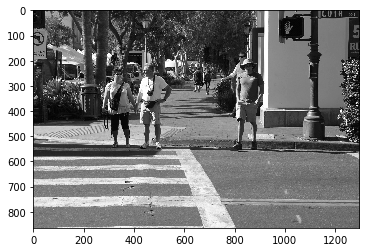

In [55]:
imagepaths = glob.glob('/home/italo/Documentos/Imag*/Val*/*.jpg', recursive=True)
imagem = imread(imagepaths[3],as_gray=True)
plot_img(imagem)

In [ ]:
def process_img(img,clf):
    threshhold = 1
    recent_heatmaps = deque(maxlen=10)
    hot_windows = find_person(img, clf)
    plot_img(img)
    img1 = np.copy(img)
    for bbox in hot_windows:  
        cv2.rectangle(img1, bbox[0], bbox[1], (0,0,255), 6)
    plot_img(img1,"All detections")
    
      # Highlight the windows
    heat = np.zeros_like(img[:,:]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    plot_img(heat,"After Applying heat")
    
    # Append the detections to detections from last n frames
    recent_heatmaps.append(heat)
    
    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),threshhold)
    plot_img(heatmap,"After threshold")
    
    # Add labels to remaning detections
    labels = label(heatmap)
    # Draw boxes on the cars and return the image
    return draw_labeled_bboxes(np.copy(img), labels)

imgfinal = process_img(imagem,clf)
plot_img(imgfinal)


#############################  ##################################


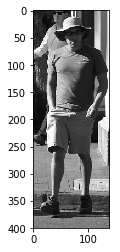

#############################  ##################################


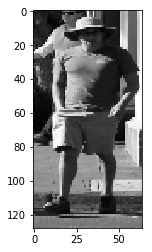

predict [1.]


In [56]:
# Select ROI
# Crop image
imCrop = imagem[180:580, 780:920]
#imCrop = imagem[580:800, 780:920]
plot_img(imCrop)

feat = cv2.resize(imCrop, (64,128))
plot_img(feat)
hog_f = get_feature(feat).reshape(1,-1)
ypred = clf.predict(hog_f)
print('predict', ypred)